In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.dates as mdates  #Importing module for date formatting
import matplotlib.ticker as ticker  # Importing ticker for customizing colorbar ticks
from scipy.ndimage import gaussian_filter
import seaborn as sns
import glob
from datetime import datetime

In [2]:
dataset = xr.open_dataset('cr-sim_output_2020_03_13_00_00_00-2020_03_13_23_59_55.nc')
# select date you want
ds = dataset.sel(time=slice("2020-03-13T04:00:00.000000000", "2020-03-13T23:59:55.500000000"))
ds

<xarray.Dataset>
Dimensions:                        (time: 16000, ny: 1, nx: 1, nz: 135, one: 1,
                                    n_layers: 10)
Coordinates:
  * time                           (time) datetime64[ns] 2020-03-13T04:00:00 ...
Dimensions without coordinates: ny, nx, nz, one, n_layers
Data variables: (12/50)
    xlat                           (time, ny, nx) float32 ...
    xlong                          (time, ny, nx) float32 ...
    Zhh                            (time, nz, ny, nx) float32 ...
    DV                             (time, nz, ny, nx) float32 ...
    SWh                            (time, nz, ny, nx) float32 ...
    SWt                            (time, nz, ny, nx) float32 ...
    ...                             ...
    azim                           (time, nz, ny, nx) float32 ...
    range                          (time, nz, ny, nx) float32 ...
    height                         (time, nz, ny, nx) float32 ...
    wcont                          (time, nz, ny, nx) float32 ...
    x_scene                        (time, nx) float32 ...
    y_scene                        (time, ny) float32 ...
Attributes: (12/15)
    description:                        forward radar simulator output
    model_version:                      crsim_v3.3
    WRF_input_file:                     profiles_d02_000000.nc
    MP_PHYSICS:                             8
    x_indices_of_WRF_extracted_scene:   1 - 1
    y_indices_of_WRF_extracted_scene:   1 - 1
    ...                                 ...
    x_and_y_indices_of_radar_position:  1 , 1
    height_of_radar:                    10.0 m
    scanning_mode:                      elevation of each scene pixel is rela...
    created_by:                         Aleksandra Tatarevic
    institute:                          http://wwww.clouds.mcgill.ca
    websites:                           https://www.bnl.gov/CMAS/cr-sim.php; ...

In [3]:
# ds['mwr_lwp']

In [3]:
# Replace 'dataset' with the actual dataset variable you have.
mask = (ds['height'] >= 0) & (ds['height'] <= 7000)  # adjust the units if necessary
dataset_masked = ds.where(mask, drop=True)
# remove nx and ny since it is having length of 1
ds_mask = dataset_masked.squeeze(['nx', 'ny'], drop=True)

In [4]:
time = ds_mask['time']
height = ds_mask['height'].mean('time')
# reflectivity at hh polarization
reflectivity = ds_mask['Zhh']
# Radial Doppler velocity
doppler_velocity = ds_mask['DV']
# Total spectral width
total_spectral_width = ds_mask['SWtot']
# liquid water path
liquid_water_path = ds_mask['mwr_lwp'].mean('nz')
# temperature
temperature = ds_mask['temp']

In [5]:
data = xr.open_dataset('RAINNC_wrfout_2020_03_13_00_00_00-2020_03_14_00_00_00.nc').squeeze('Time')
data = data.sel(time=slice("2020-03-13T04:00:00.000000000", "2020-03-14T00:00:00.000000000"))
data_andenes = data.isel(south_north=282, west_east=1651)
data_andenes

<xarray.Dataset>
Dimensions:  (time: 241)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14
Data variables:
    RAINNC   (time) float32 ...

In [6]:
times = data_andenes['time']
rainnc = data_andenes['RAINNC']

datas = {"time": times,"rainnc": rainnc}

df = pd.DataFrame(data=datas)
# ==================
# Ensure the DataFrame is sorted by time
df.sort_values(by='time', inplace=True)

# Calculate the difference in precipitation to get the change per 5 minutes
df['rainnc_change_5min'] = df['rainnc'].diff()

# Convert the 5-minute precipitation change to an hourly rate
# by multiplying by 12 (since there are 12, 5-minute intervals in an hour)
df['rainnc_rate_mm_per_hr'] = df['rainnc_change_5min'] * 12

# Handling the first NaN value in 'rainnc_change_5min' and 'rainnc_rate_mm_per_hr'
df['rainnc_change_5min'].fillna(0, inplace=True)
df['rainnc_rate_mm_per_hr'].fillna(0, inplace=True)

# Display the DataFrame to verify the results
df

,time,rainnc,rainnc_change_5min,rainnc_rate_mm_per_hr
0,2020-03-13 04:00:00,7.102650,0.000000,0.000000
1,2020-03-13 04:05:00,7.141771,0.039122,0.469460
2,2020-03-13 04:10:00,7.182107,0.040336,0.484028
3,2020-03-13 04:15:00,7.197089,0.014982,0.179781
4,2020-03-13 04:20:00,7.202566,0.005477,0.065723
...,...,...,...,...
236,2020-03-13 23:40:00,11.295522,0.000000,0.000000
237,2020-03-13 23:45:00,11.295522,0.000000,0.000000
238,2020-03-13 23:50:00,11.295522,0.000000,0.000000
239,2020-03-13 23:55:00,11.296454,0.000933,0.011192


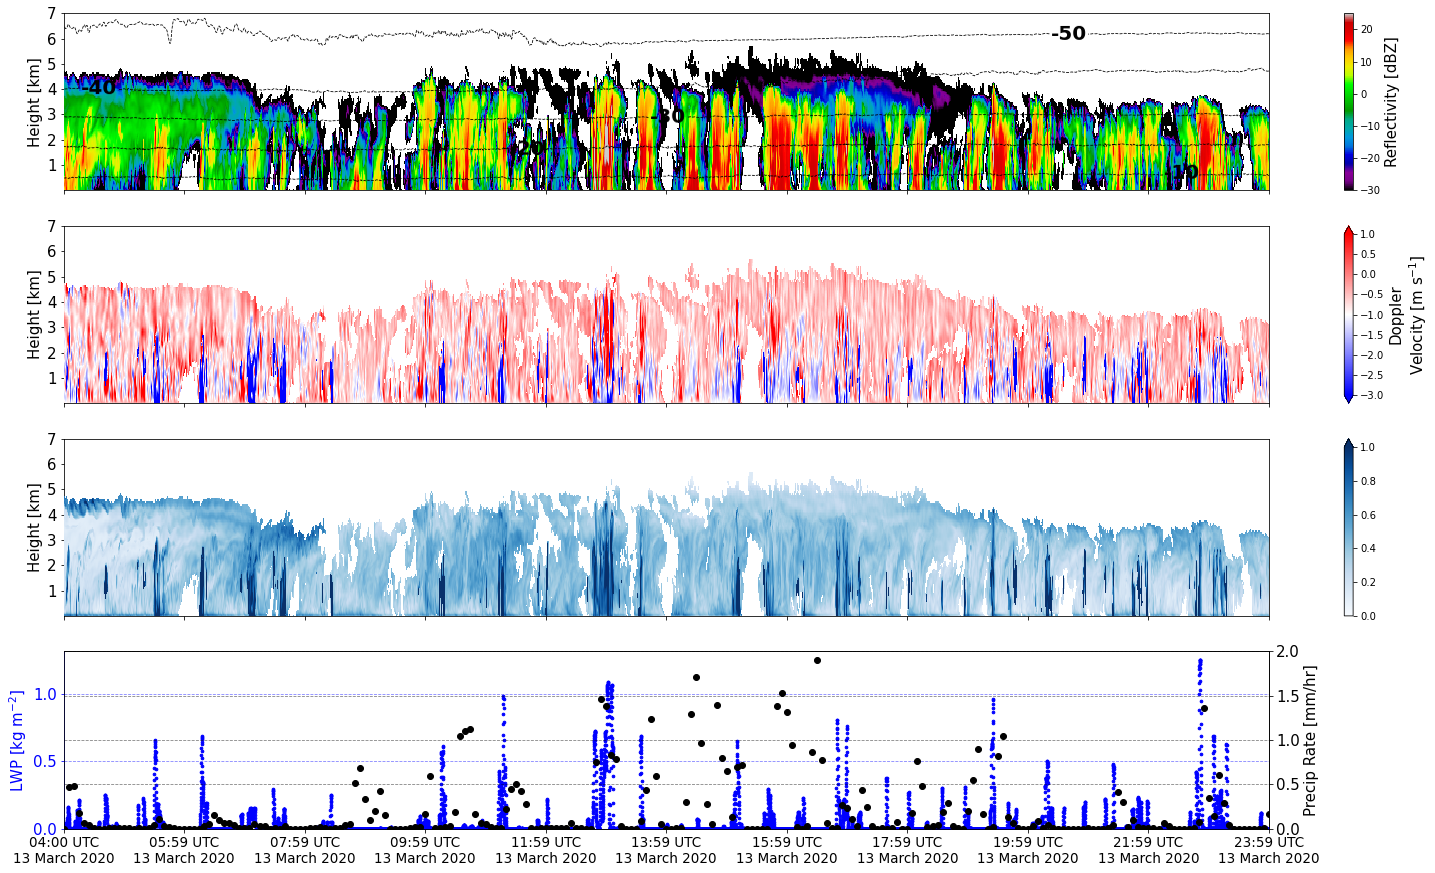

In [19]:
fig, ax = plt.subplots(figsize=(27, 15), nrows=4, ncols=1, sharex=True)
ax = ax.flatten()

for i, v in enumerate(ax):
    if i == 0:
        pcm = ax[i].pcolormesh(time, height/1000.0, reflectivity.T, cmap='nipy_spectral', vmin=-30, vmax=25, zorder=5)
        # temperature
        cntr = ax[i].contour(time[::2], height[::2]/1000, temperature.T[::2, ::2], np.round(np.arange(-100,320, 10)), colors='k', 
                             linewidths=0.8, linestyles ="dashed", zorder=6)
        clabels = plt.clabel(cntr,inline=1, inline_spacing=8, fontsize=20, fmt='%i', manual=False)
        # Set the weight to bold for all labels
        for txt in clabels:
            txt.set_weight('bold')
            txt.set_color('black')
        
        ax[i].set_ylim(0, 7)
        # Set y-axis ticks
        ax[i].set_yticks(np.arange(1, 8))
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_ylabel('Height [km]', color='black', fontsize=15)  # Label for the twin y-axis
        cbar = fig.colorbar(pcm, ax=ax[i])
        cbar.set_label('Reflectivity [dBZ]', fontsize=15)
         # Set colorbar ticks at an interval of 10 (adjust as needed)
        tick_locator = ticker.MultipleLocator(base=10)
        cbar.locator = tick_locator
        cbar.update_ticks()


    if i == 1:
        pcm = ax[i].pcolormesh(time, height/1000.0, doppler_velocity.T,
                                   cmap='bwr', vmin=-3, vmax=1, zorder=5)
        ax[i].set_ylim(0, 7)
        # Set y-axis ticks
        ax[i].set_yticks(np.arange(1, 8))
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_ylabel('Height [km]', color='black', fontsize=15)  # Label for the twin y-axis
        cbar = fig.colorbar(pcm, ax=ax[i], extend='both')
        cbar.set_label("Doppler\nVelocity [m s$^{-1}$]", fontsize=15)


    if i == 2:
            pcm = ax[i].pcolormesh(time, height/1000.0, total_spectral_width.T,
                                   cmap='Blues', vmin=0, vmax=1, zorder=5)
            ax[i].set_ylim(0, 7)
            # Set y-axis ticks
            ax[i].set_yticks(np.arange(1, 8))
            ax[i].tick_params(axis='y', labelsize=15)
            ax[i].set_ylabel('Height [km]', color='black', fontsize=15)  # Label for the twin y-axis
            cbar = fig.colorbar(pcm, ax=ax[i], extend='max')

    if i == 3:
        pcm = ax[i].scatter(time, liquid_water_path, color='blue', zorder=3, s=7)
        ax[i].set_yticks(np.arange(0, np.max(liquid_water_path.values), 0.5))
        ax[i].set_ylim(0, )
        ax[i].spines['left'].set_color('blue')
        ax[i].tick_params(axis='y', colors='blue', labelsize=15)
        ax[i].set_ylabel("LWP [kg m$^{-2}$]", c = "blue", fontsize=15)
        cbar = fig.colorbar(pcm, ax=ax[i], extend='neither')
        # set colorbar to invisible
        cbar.ax.set_visible(False)
        ax[i].grid(axis="y", ls = '--', c = "blue",alpha = 0.5)

        # Create a twin y-axis for ax[2]
        ax31 = ax[3].twinx()
        ax31.scatter(df['time'], df['rainnc_rate_mm_per_hr'], color='black')
        ax31.spines['right'].set_color('black')
        ax31.tick_params(axis='y', colors='black', labelsize=15)
        ax31.set_ylabel('Precip Rate [mm/hr]', color='black', fontsize=15) 
        # ax31.set_yticks(np.arange(0, df['rainnc_rate_mm_per_hr'])+0.1)
        ax31.grid(axis="y", ls = '--', c = "black",alpha = 0.5)
        ax31.set_ylim(0, 2)
        ax31.set_yticks(np.arange(0, 2.5, 0.5))


        

        

    # Custom datetime format
    custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format: 04:00 UTC\n13 March 2020
    # Formatting the time labels
    ax[len(ax)-1].xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))
    # Including the first-date and last-date on the plot
    ax[len(ax)-1].set_xlim([ds['time'].min(), ds['time'].max()])
    # Set custom tick positions for the x-axis
    num_ticks = 11  # Number of tick labels
    tick_positions = np.linspace(0, len(ds['time']) - 1, num_ticks, dtype=int)
    ax[len(ax)-1].set_xticks(ds['time'][tick_positions])

    # Generate custom tick labels including the first and last dates
    tick_labels = [ds['time'][pos].dt.strftime(custom_date_format).values for pos in tick_positions]
    tick_labels[0] = ds['time'].min().dt.strftime(custom_date_format).values  # First date
    tick_labels[-1] = ds['time'].max().dt.strftime(custom_date_format).values  # Last date
    ax[len(ax)-1].set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # You can adjust fontsize and rotation

# fig.savefig("open-les.jpg", dpi=500, bbox_inches='tight')

In [17]:
np.max(liquid_water_path.values)

1.2578517

In [11]:
data = xr.open_dataset('RAINNC_wrfout_2020_03_13_00_00_00-2020_03_14_00_00_00.nc').squeeze('Time')
data = data.sel(time=slice("2020-03-13T04:00:00.000000000", "2020-03-14T00:00:00.000000000"))
data_andenes = data.isel(south_north=282, west_east=1651)
data_andenes

<xarray.Dataset>
Dimensions:  (time: 241)
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14
Data variables:
    RAINNC   (time) float32 ...

In [12]:
time = data_andenes['time']
rainnc = data_andenes['RAINNC']

datas = {"time": time,"rainnc": rainnc}

df = pd.DataFrame(data=datas)
# ==================
# Ensure the DataFrame is sorted by time
df.sort_values(by='time', inplace=True)

# Calculate the difference in precipitation to get the change per 5 minutes
df['rainnc_change_5min'] = df['rainnc'].diff()

# Convert the 5-minute precipitation change to an hourly rate
# by multiplying by 12 (since there are 12, 5-minute intervals in an hour)
df['rainnc_rate_mm_per_hr'] = df['rainnc_change_5min'] * 12

# Handling the first NaN value in 'rainnc_change_5min' and 'rainnc_rate_mm_per_hr'
df['rainnc_change_5min'].fillna(0, inplace=True)
df['rainnc_rate_mm_per_hr'].fillna(0, inplace=True)

# Display the DataFrame to verify the results
df

,time,rainnc,rainnc_change_5min,rainnc_rate_mm_per_hr
0,2020-03-13 04:00:00,7.102650,0.000000,0.000000
1,2020-03-13 04:05:00,7.141771,0.039122,0.469460
2,2020-03-13 04:10:00,7.182107,0.040336,0.484028
3,2020-03-13 04:15:00,7.197089,0.014982,0.179781
4,2020-03-13 04:20:00,7.202566,0.005477,0.065723
...,...,...,...,...
236,2020-03-13 23:40:00,11.295522,0.000000,0.000000
237,2020-03-13 23:45:00,11.295522,0.000000,0.000000
238,2020-03-13 23:50:00,11.295522,0.000000,0.000000
239,2020-03-13 23:55:00,11.296454,0.000933,0.011192


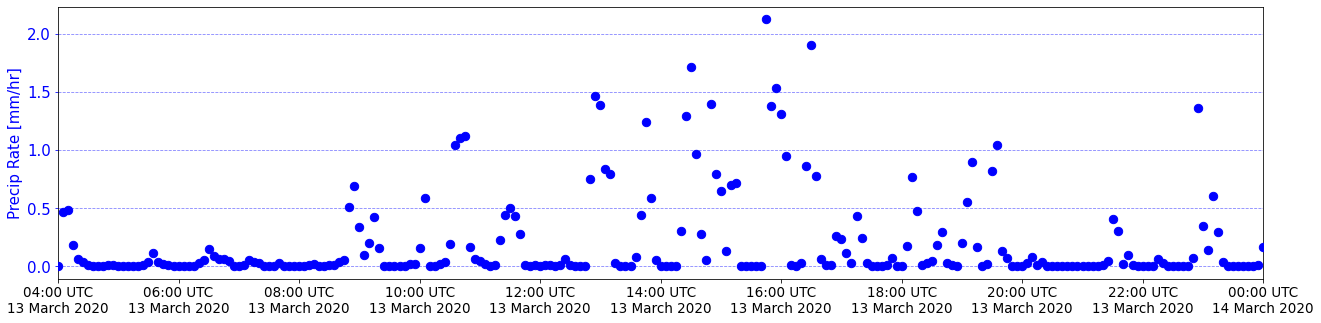

In [13]:
fig, ax = plt.subplots(figsize=(27, 5), nrows=1, ncols=1, sharex=True)
pcm = ax.scatter(df['time'], df['rainnc_rate_mm_per_hr'], color='blue', zorder=3, s=70)

ax.tick_params(axis='y', colors='blue', labelsize=15)
ax.set_ylabel("Precip Rate [mm/hr]", c = "blue", fontsize=15)
cbar = fig.colorbar(pcm, ax=ax, extend='neither')
# # set colorbar to invisible
cbar.ax.set_visible(False)
ax.grid(axis="y", ls = '--', c = "blue",alpha = 0.5)




    
    # Custom datetime format
custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format example: 04:00 UTC\n13 March 2020

# Formatting the x-axis with datetime information
ax.xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))

# Setting the xlim to cover the full range of dates
ax.set_xlim([df['time'].min(), df['time'].max()])

# Custom tick positions and labels for the x-axis
num_ticks = 11  # Number of tick labels
tick_positions = np.linspace(0, len(df['time']) - 1, num_ticks, dtype=int)
tick_labels = [df['time'].iloc[pos].strftime(custom_date_format) for pos in tick_positions]
ax.set_xticks(df['time'].iloc[tick_positions])
ax.set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # Adjust fontsize and rotation as needed
# fig.savefig("precip-rate.jpg", dpi=500, bbox_inches='tight')

In [14]:
df['time']

0     2020-03-13 04:00:00
1     2020-03-13 04:05:00
2     2020-03-13 04:10:00
3     2020-03-13 04:15:00
4     2020-03-13 04:20:00
              ...        
236   2020-03-13 23:40:00
237   2020-03-13 23:45:00
238   2020-03-13 23:50:00
239   2020-03-13 23:55:00
240   2020-03-14 00:00:00
Name: time, Length: 241, dtype: datetime64[ns]

In [15]:
# len(time), len(liquid_water_path)
time

<xarray.DataArray 'time' (time: 241)>
array(['2020-03-13T04:00:00.000000000', '2020-03-13T04:05:00.000000000',
       '2020-03-13T04:10:00.000000000', ..., '2020-03-13T23:50:00.000000000',
       '2020-03-13T23:55:00.000000000', '2020-03-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14

In [21]:
# len(reflectivity)

16000

TypeError: Dimensions of C (117, 16000) are incompatible with X (241) and/or Y (117); see help(pcolormesh)

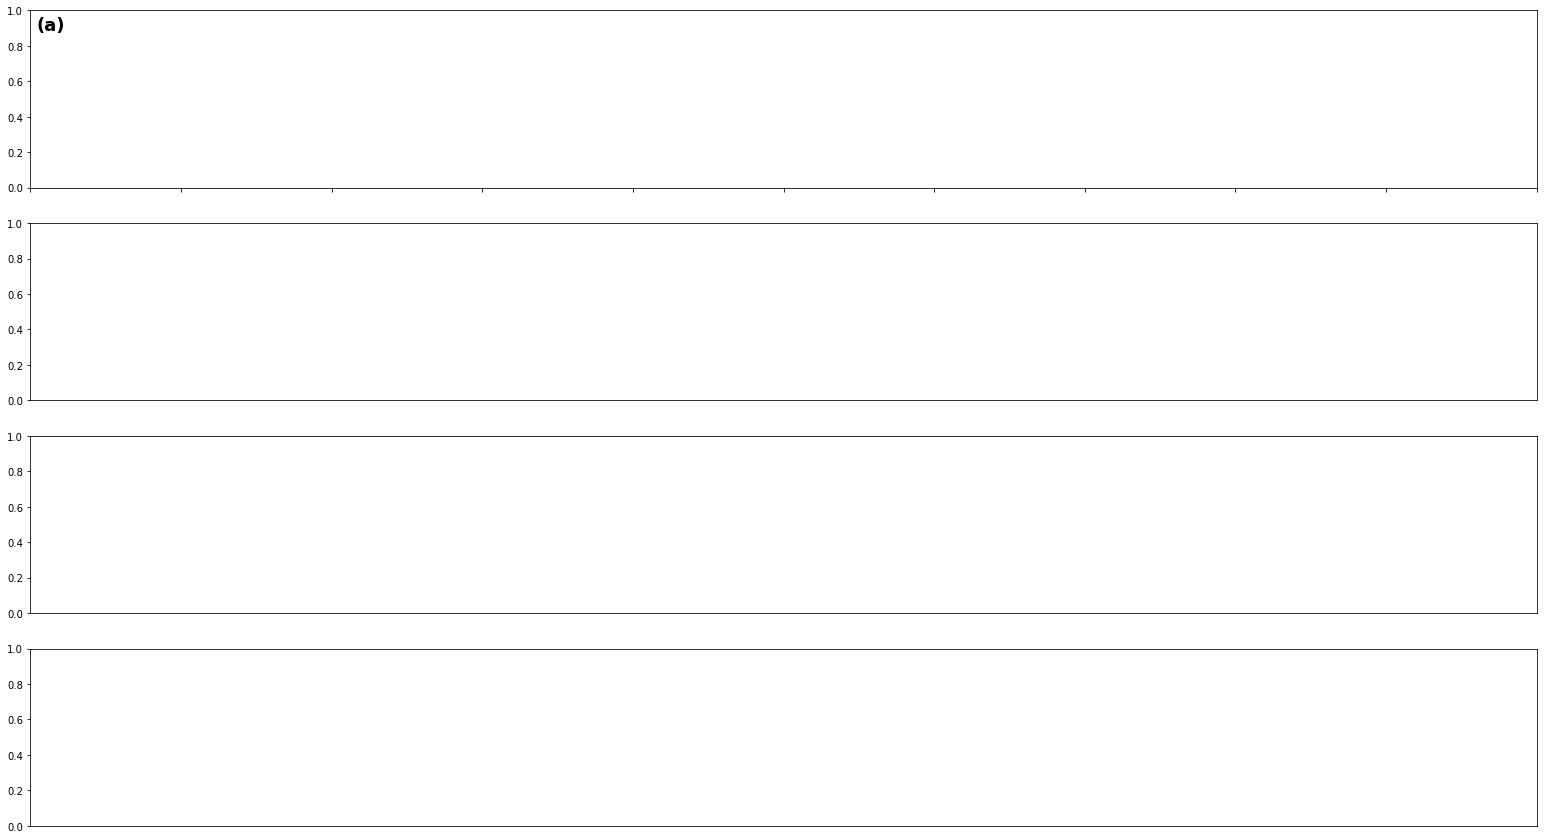

In [11]:
# Your initial setup for the plot
fig, ax = plt.subplots(figsize=(27, 15), nrows=4, ncols=1, sharex=True)
ax = ax.flatten()

for i, v in enumerate(ax):
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
    ax[i].text(0.004, 0.97, labels[i], transform=ax[i].transAxes, fontsize=18, va='top', ha='left', fontweight='bold')
    
    if i == 0:
        pcm = ax[i].pcolormesh(time, height/1000.0, reflectivity.T, cmap='nipy_spectral', vmin=-30, vmax=25, zorder=5)
        cntr = ax[i].contour(time[::2], height[::2]/1000, temperature.T[::2, ::2], np.round(np.arange(-100,320, 10)), colors='k', linewidths=0.8, linestyles="dashed", zorder=6)
        clabels = plt.clabel(cntr, inline=1, inline_spacing=8, fontsize=20, fmt='%i', manual=False)
        for txt in clabels:
            txt.set_weight('bold')
            txt.set_color('black')
        ax[i].set_ylim(0, 7)
        ax[i].set_yticks(np.arange(1, 8))
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_ylabel('Height [km]', color='black', fontsize=15)
        cbar = fig.colorbar(pcm, ax=ax[i])
        cbar.set_label('Reflectivity [dBZ]', fontsize=15)
        tick_locator = ticker.MultipleLocator(base=10)
        cbar.locator = tick_locator
        cbar.update_ticks()

    if i == 1:
        pcm = ax[i].pcolormesh(time, height/1000.0, doppler_velocity.T, cmap='bwr', vmin=-3, vmax=1, zorder=5)
        ax[i].set_ylim(0, 7)
        ax[i].set_yticks(np.arange(1, 8))
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_ylabel('Height [km]', color='black', fontsize=15)
        cbar = fig.colorbar(pcm, ax=ax[i], extend='both')
        cbar.set_label("Doppler\nVelocity [m s$^{-1}$]", fontsize=15)

    if i == 2:
        pcm = ax[i].pcolormesh(time, height/1000.0, total_spectral_width.T, cmap='Blues', vmin=0, vmax=1, zorder=5)
        ax[i].set_ylim(0, 7)
        ax[i].set_yticks(np.arange(1, 8))
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_ylabel('Height [km]', color='black', fontsize=15)
        cbar = fig.colorbar(pcm, ax=ax[i], extend='max')

    if i == 3:
        pcm = ax[i].scatter(time, liquid_water_path, color='blue', zorder=3, s=7)
        ax[i].set_yticks(np.arange(0, round(np.nanmax(liquid_water_path))+0.1, 0.5))
        ax[i].spines['left'].set_color('blue')
        ax[i].tick_params(axis='y', colors='blue', labelsize=15)
        ax[i].set_ylabel("LWP [kg m$^{-2}$]", color="blue", fontsize=15)
        cbar = fig.colorbar(pcm, ax=ax[i], extend='neither')
        cbar.ax.set_visible(False)
        ax[i].grid(axis="y", ls='--', color="blue", alpha=0.5)

# # Modifications for 6-hour intervals on the x-axis
time_series = pd.to_datetime(time)  # Convert 'time' to pandas datetime series if not already
time_range = pd.date_range(start=time_series.min(), end=time_series.max(), freq='1.5H')
ax[-1].set_xticks(time_range)
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M UTC\n%d %B %Y"))
ax[-1].set_xticklabels([t.strftime("%H:%M UTC\n%d %B %Y") for t in time_range], fontsize=10.5, rotation=0)
    # ax[len(ax)-1].set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # You can adjust fontsize and rotation

# Assuming ds['time'] is your dataset's time variable, adjust accordingly
# This part might need adjustment based on your actual 'time' data structure
ax[-1].set_xlim([time_series.min(), time_series.max()])

# Saving the figure if needed
# fig.savefig("open-les.jpg", dpi=500, bbox_inches='tight')

In [39]:
pwd

'/glade/work/noteng/masters-research/comble/LES'